In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/content/all_stocks_5yr.csv')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date    open    high      low   close   volume  Name
444924  2017-06-02  117.46  117.70  117.040  117.67  3162869   PEP
369656  2016-07-12   98.20  100.55   97.975  100.17   965911   MCO
372975  2014-09-16   54.74   55.53   54.730   55.25  3283928   MET
209366  2017-07-31   76.24   76.88   76.000   76.72  1699164   ETR
607272  2016-05-16   42.98   43.82   42.980   43.51  2853744  XLNX
377329  2016-12-29   92.91   93.79   92.910   93.67   579404   MKC
54440   2015-02-03   67.39   68.43   67.050   68.06  5682031   APA


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [5]:

data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


EDA

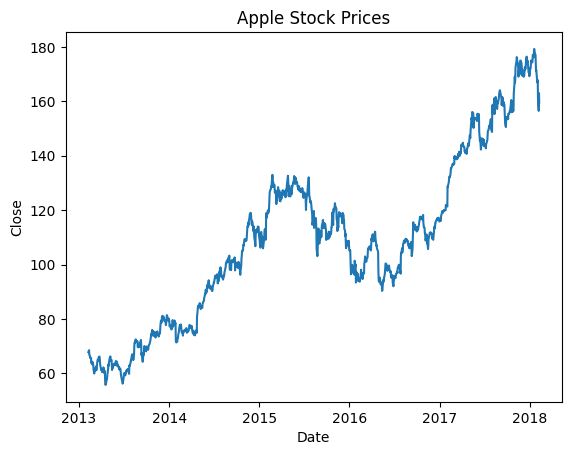

In [8]:

apple = data[data['Name'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1))
 & (apple['date']<datetime(2018,1,1))]
plt.plot(apple['date'],apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [9]:

close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Training Model

In [11]:

model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7a8bc90b90f0>>

In [12]:

model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
36/36 [==============================] - 8s 62ms/step - loss: 0.0247
Epoch 2/10
36/36 [==============================] - 3s 76ms/step - loss: 0.0094
Epoch 3/10
36/36 [==============================] - 2s 60ms/step - loss: 0.0090
Epoch 4/10
36/36 [==============================] - 2s 64ms/step - loss: 0.0086
Epoch 5/10
36/36 [==============================] - 3s 97ms/step - loss: 0.0075
Epoch 6/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0069
Epoch 7/10
36/36 [==============================] - 2s 59ms/step - loss: 0.0072
Epoch 8/10
36/36 [==============================] - 2s 59ms/step - loss: 0.0076
Epoch 9/10
36/36 [==============================] - 2s 59ms/step - loss: 0.0067
Epoch 10/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0060


In [13]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 [==============================] - 1s 21ms/step
MSE 23.931281074504888
RMSE 4.891960861914667


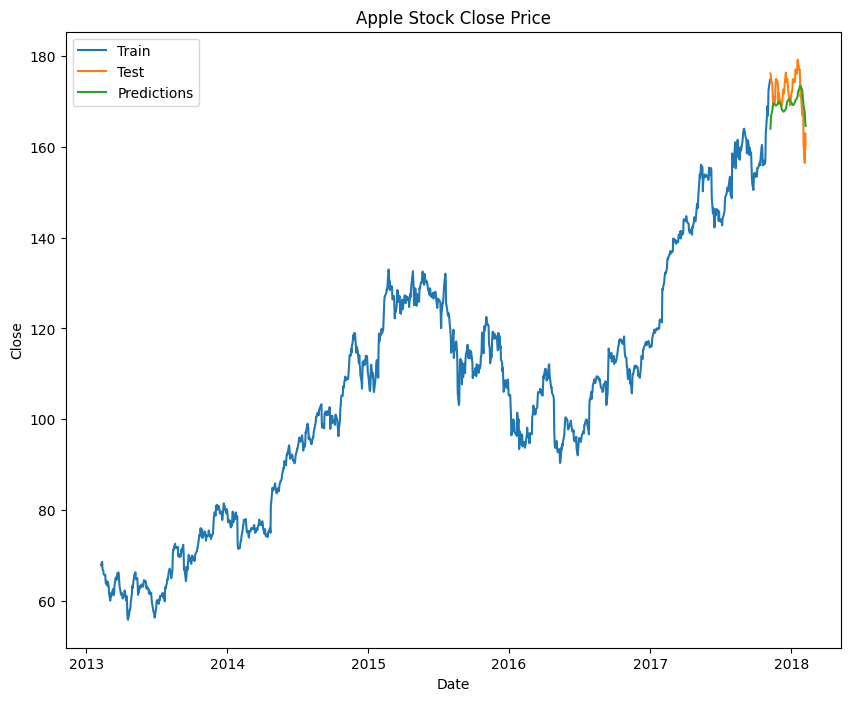

In [16]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])